{'record_name': 'voice001', 'n_sig': 1, 'fs': 8000, 'counter_freq': None, 'base_counter': None, 'sig_len': 38080, 'base_time': None, 'base_date': None, 'comments': ['<age>: 32  <sex>: M <diagnoses>: hyperkinetic dysphonia <medications>: none'], 'sig_name': ['voice'], 'p_signal': array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       ...,
       [ 0.00354004],
       [-0.03735352],
       [-0.02871704]], shape=(38080, 1)), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['voice001.dat'], 'fmt': ['32'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [None], 'adc_gain': [4079702243.3775], 'baseline': [-260023747], 'units': ['NU'], 'adc_res': [0], 'adc_zero': [0], 'init_value': [-260023747], 'checksum': [14973], 'block_size': [0]}


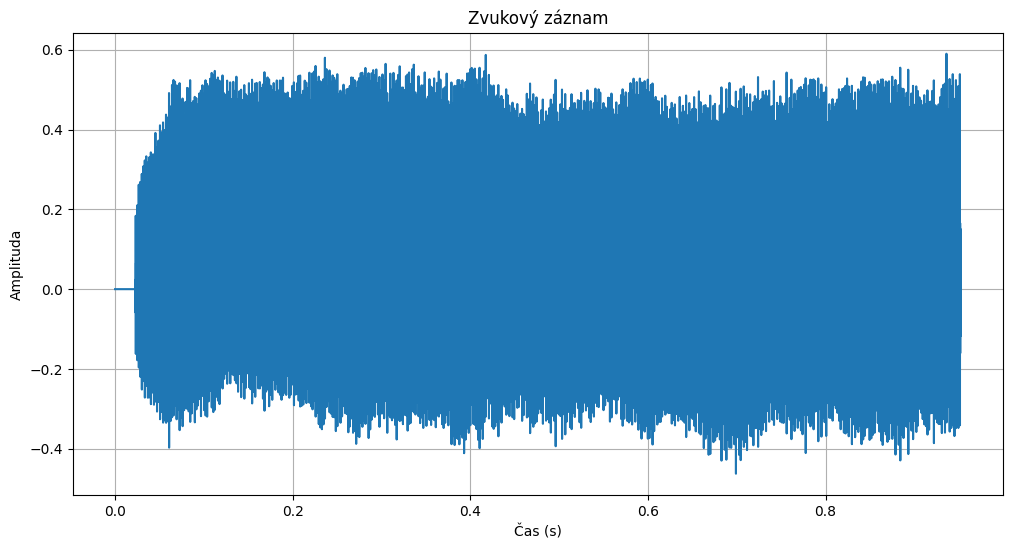

C:\Users\imang\AppData\Local\Temp\ipykernel_21156\3016209973.py:44: RuntimeWarning: divide by zero encountered in log
  log_sp = np.log(modified_spectrum**2)


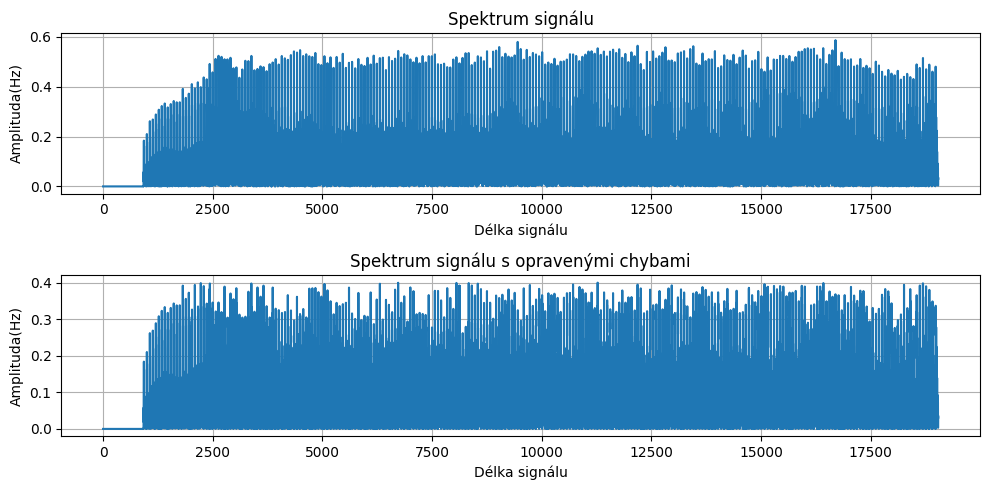

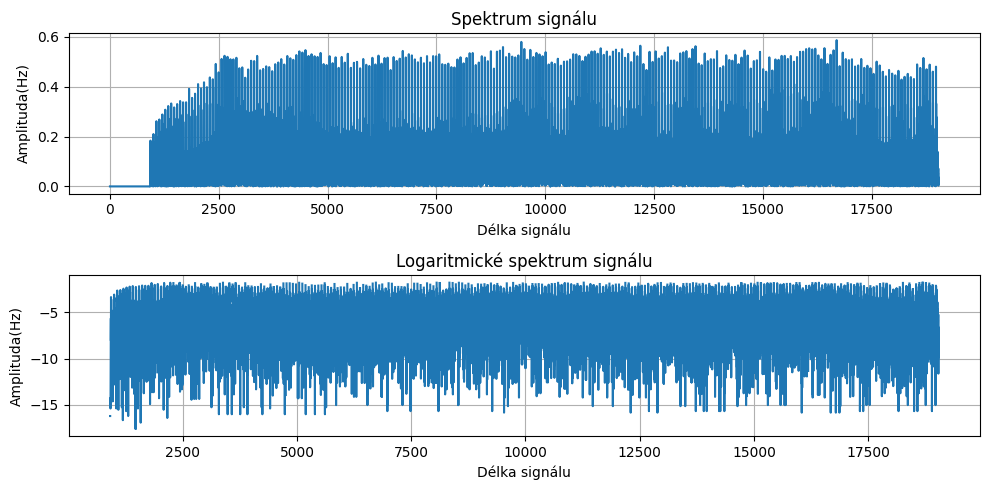

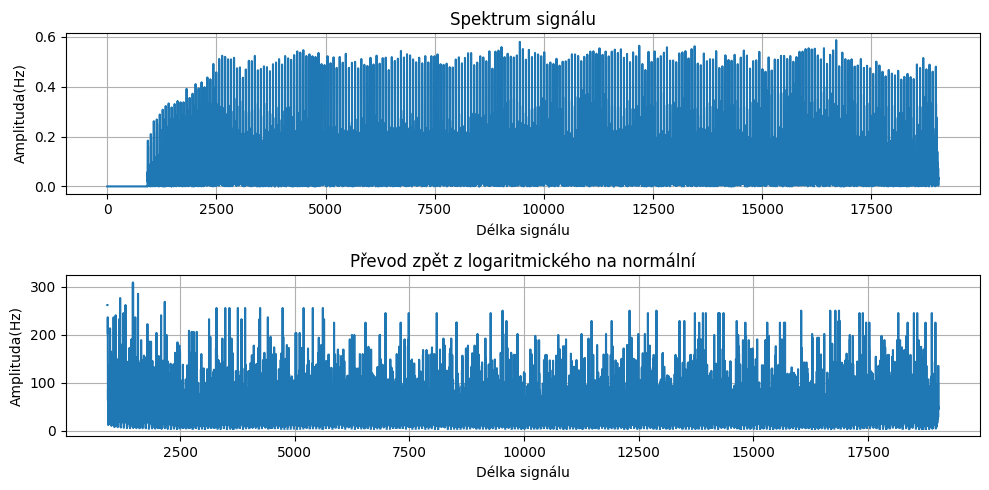

C:\Users\imang\AppData\Local\Temp\ipykernel_21156\3016209973.py:80: RuntimeWarning: divide by zero encountered in log
  log_sp = np.log(spectrum)#+np.finfo(float).eps) #zlogaritmování + přidání eps pro přesnost


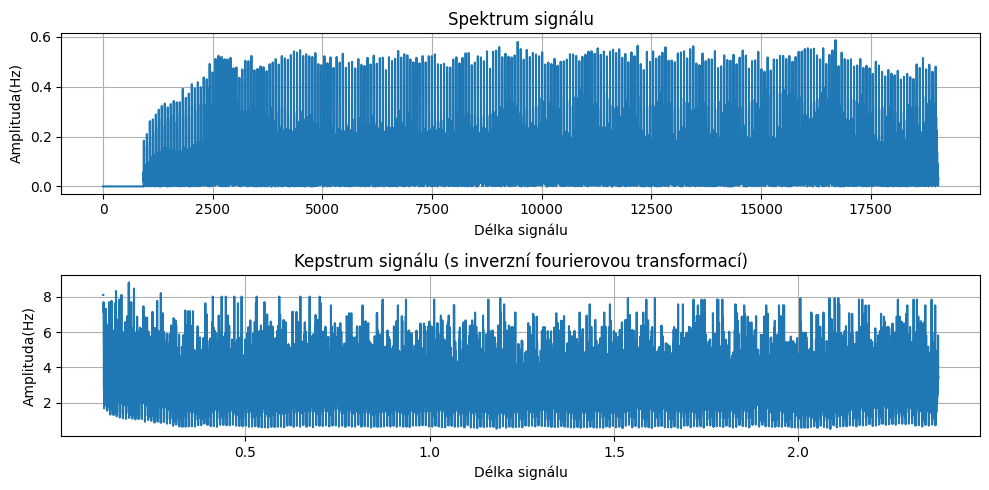

C:\Users\imang\AppData\Local\Temp\ipykernel_21156\3016209973.py:88: RuntimeWarning: divide by zero encountered in log
  log_sp = np.log(np.abs(np.fft.fft(signal)))


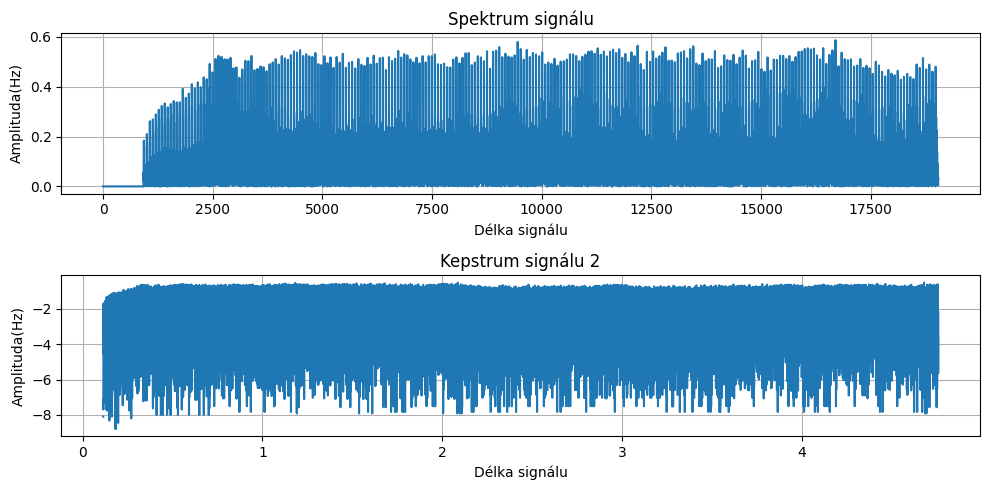

C:\Users\imang\AppData\Local\Temp\ipykernel_21156\3016209973.py:107: UserWarning: Input data is complex, switching to return_onesided=False
  f, t, Zxx = stft(np.fft.fft(signal),fs=vz_f, nperseg=256)


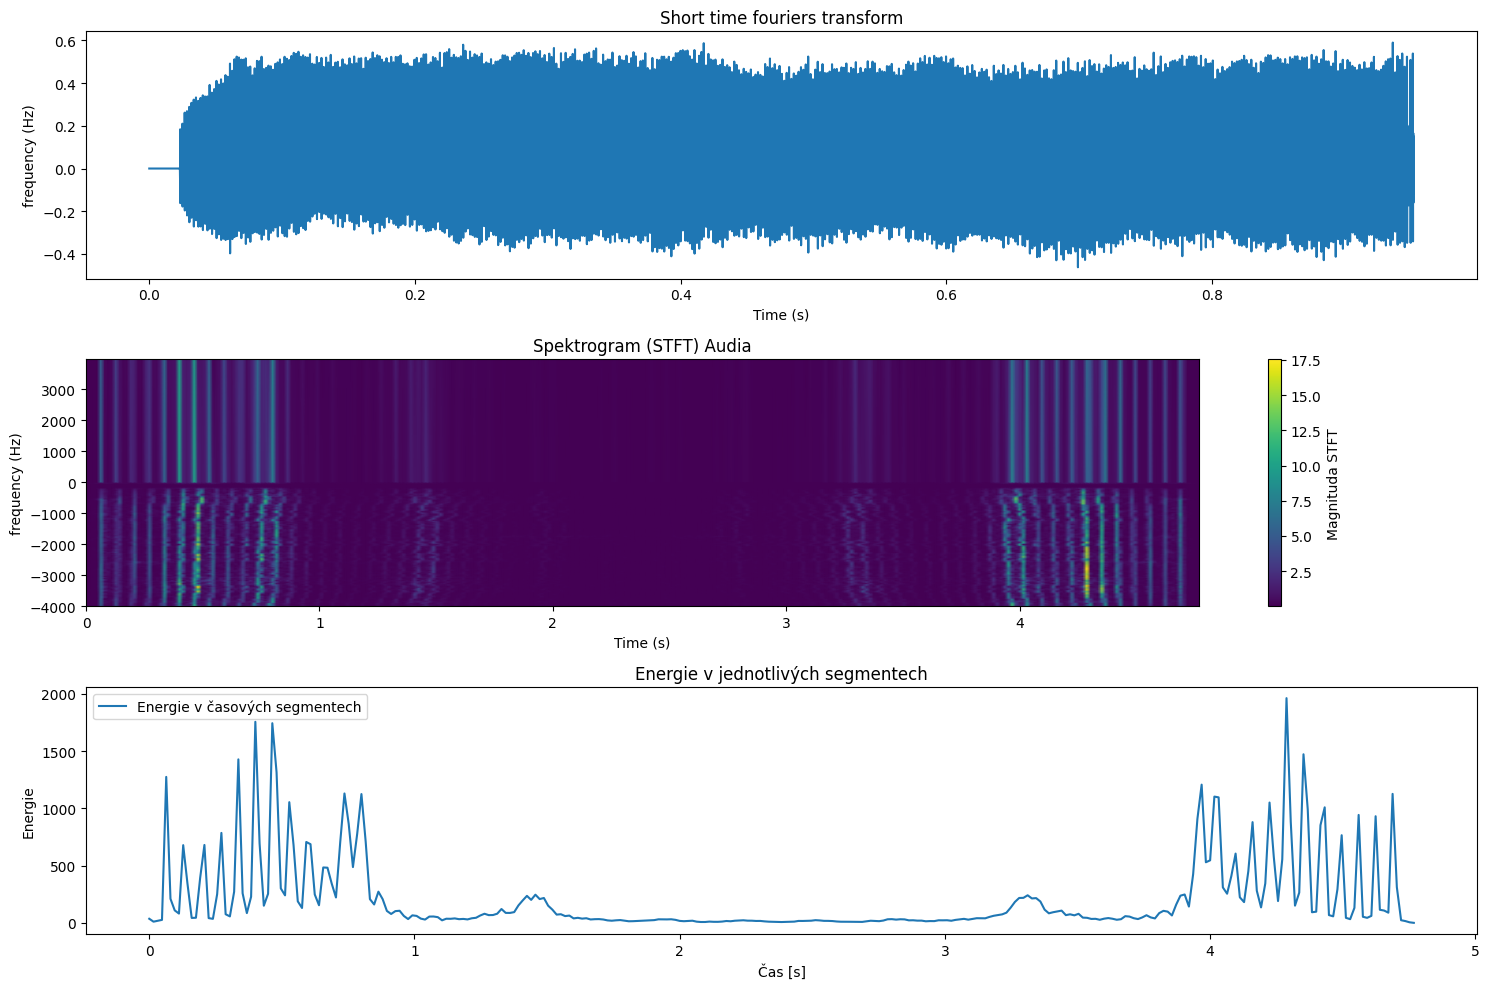

In [ ]:
#úkol: klasifikace zvukových signálů na dobré a patologické pomocí různých technik pomocí Fourierovy a kepstrální analýzy,... v případe klasifikujte poruchy + porovnat s technikami které provedli experti
#výstup: grafy demostrující práci se signálem v časové nebo frekvenční oblasti, viualizace a klasifikace v prostoru nebo pomocí parametrů, tabulka s úspěšností klasifikace na jednotlivé skupiny a patologické signály.
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import stft

def Nacti_soubor(cesta_k_souboru): return wfdb.rdrecord(cesta_k_souboru)

#nejdřív si vykreslím zvukový signál
def plot_audio(time_axis,signal):
    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, signal)
    plt.title("Zvukový záznam"); plt.xlabel("Čas (s)"); plt.ylabel("Amplituda")
    plt.grid()
    plt.show()

def play_audio(signal, fs, carrier_freq=100):
    import sounddevice as sd
    sd.play((signal*32767).astype(np.int16),samplerate=fs)
    sd.wait()

record = Nacti_soubor(r"C:\Users\imang\OneDrive\Plocha\PZS\seminarni_prace_2\zvukove_stopy\voice001") #načtu si zvukový soubor
print(f"{record.__dict__}") #Načtu si informace o zvukové nahrávce, abych věděl, co obsahuje.

signal = record.p_signal #vezmu si ze souboru signál zvuku
vz_f = record.fs #vzorkovací frekvence zvuku
time = len(signal)/(vz_f*5) 
time_axis = np.linspace(0,time,len(signal)) #vytvořím časovou osu zvuku

plot_audio(time_axis,signal)
play_audio(signal, vz_f) 

#fourierova transformace signálu
def fft_transform(signal, down_limit):
    signal_range = len(signal)//2
    _1D_f_t = np.fft.fft(signal)
    spectrum = np.abs(_1D_f_t[:signal_range])
    fqs_t = np.arange(spectrum.size)    
    #remove errors higher then down limit
    modified_spectrum = spectrum.copy()
    modified_spectrum[modified_spectrum>down_limit] = 0
    log_sp = np.log(modified_spectrum**2)
    return fqs_t, spectrum, modified_spectrum, log_sp

down_limit = 0.4 #dolní hranice 0.5 Hz

#zde jsem useknul přes fourierovu transformaci frekvence vyšší než 0.5 Hz
fqs, spectrum, modified_spectrum, log_spectrum = fft_transform(signal,down_limit)


def plot_fft_signal(fqs_axis, spectrum, fqs2_axis, modified_spectrum, title_name="Spektrum signálu s opravenými chybami"):
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.plot(fqs_axis, spectrum)
    plt.title("Spektrum signálu")
    plt.xlabel("Délka signálu")
    plt.ylabel("Amplituda(Hz)")
    plt.grid()
    plt.subplot(2, 1, 2)
    plt.plot(fqs2_axis, modified_spectrum)
    plt.title(title_name)
    plt.xlabel("Délka signálu")
    plt.ylabel("Amplituda(Hz)")
    plt.grid()
    plt.tight_layout()
    plt.show()

plot_fft_signal(fqs, spectrum,fqs, modified_spectrum) #vykreslím modifikovaný signál
#play_audio(modified_spectrum,vz_f) #následně si přehraji modifikovaný signál

plot_fft_signal(fqs,spectrum,fqs,log_spectrum, title_name="Logaritmické spektrum signálu")
#play_audio(log_spectrum,vz_f)
plot_fft_signal(fqs,spectrum,fqs,np.abs(np.fft.fft(log_spectrum))**2, title_name="Cepstrum")

#inverzní fft
def inverse_fft(signal, fs):
    spectrum = np.abs(fft(signal)) #udělám fourierovu transformaci
    log_sp = np.log(spectrum)#+np.finfo(float).eps) #zlogaritmování + přidání eps pro přesnost
    invers_fft = np.abs(ifft(log_sp)) #kepstrální analýza
    ifft_time_axis = np.arange(len(invers_fft))/fs #vytvoření časové osy pro kepstrální analýzu
    ifft_range = len(invers_fft)//2 #určím si delku rozsahu kterou budu vykreslovat
    return ifft_time_axis[:ifft_range], invers_fft[:ifft_range]

#inverzní fft2
def inverse_fft2(signal, fs):
    log_sp = np.log(np.abs(np.fft.fft(signal)))
    inverse_fft = np.fft.ifft(log_sp).real #kepstrální analýza 2
    ifft_time_axis = np.arange(len(inverse_fft))/fs
    ifft_range = len(inverse_fft)
    frequencies = np.fft.fftfreq(len(signal), d=1/fs) 
    return ifft_time_axis[:ifft_range], inverse_fft[:ifft_range], frequencies[:ifft_range], log_sp[:ifft_range]

inverse_fft_time, inverse_fft_ = inverse_fft(signal,vz_f)
plot_fft_signal(fqs,spectrum,inverse_fft_time, inverse_fft_, title_name="Kepstrum signálu (s inverzní fourierovou transformací)")
#play_audio(inverse_fft_,vz_f)

inverse_fft_time,inverse_fft_, log_time, log_sp = inverse_fft2(signal,vz_f)
plot_fft_signal(fqs,spectrum,inverse_fft_time, inverse_fft_,title_name="Kepstrum signálu 2")
#play_audio(inverse_fft_, vz_f)

#short time fouriers transform
if signal.ndim > 1:
    signal = signal.mean(axis=1)

f, t, Zxx = stft(np.fft.fft(signal),fs=vz_f, nperseg=256)
energy=np.sum(np.abs(Zxx),axis=0)
plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
plt.plot(time_axis,signal)
plt.title("Short time fouriers transform")
plt.ylabel("frequency (Hz)")
plt.xlabel("Time (s)")
plt.subplot(3, 1, 2)
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.colorbar(label='Magnituda STFT')
plt.ylabel("frequency (Hz)")
plt.xlabel("Time (s)")
plt.title('Spektrogram (STFT) Audia')
plt.subplot(3, 1, 3)
plt.plot(t, energy, label='Energie v časových segmentech')
plt.xlabel('Čas [s]')
plt.ylabel('Energie')
plt.title('Energie v jednotlivých segmentech')
plt.legend()
plt.tight_layout()
plt.show()

